In [1]:
from google.colab import files
files.upload()

# Move the kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
# Download Dataset from Kaggle
!kaggle datasets download -d alvinbintang/dataset-sibi
!unzip dataset-sibi.zip -d dataset-sibi

Streaming output truncated to the last 5000 lines.
  inflating: dataset-sibi/skripsi/B/1645946451.0243402_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645946454.6260056_U.jpg  
  inflating: dataset-sibi/skripsi/B/1645946456.4885087_F.jpg  
  inflating: dataset-sibi/skripsi/B/1645946460.4972847_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645946463.7729926_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645946467.532869_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949132.0273714_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949136.465165_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949142.7455149_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949858.470701_Q.jpg  
  inflating: dataset-sibi/skripsi/B/1645949859.1649747_C.jpg  
  inflating: dataset-sibi/skripsi/B/1645949859.858002_Q.jpg  
  inflating: dataset-sibi/skripsi/B/1645949860.5160742_G.jpg  
  inflating: dataset-sibi/skripsi/B/1645949860.9303768_C.jpg  
  inflating: dataset-sibi/skripsi/B/1645949863.3891625_C.jpg  
  inflat

In [3]:
# Import Library
import os
import random
import shutil
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.models import load_model
from shutil import copyfile
from tqdm import tqdm
from os import getcwd

In [4]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [5]:
# Extract Dataset
dataset_dir = 'dataset-sibi/skripsi'
img_height, img_width = 150, 150
batch_size = 32

In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# Data Generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 4224 images belonging to 24 classes.
Found 1056 images belonging to 24 classes.


In [7]:
# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [8]:
# Train Model
epochs = 100
validation_steps=validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs)

Epoch 1/100
132/132 [==============================] - 37s 230ms/step - loss: 3.1986 - accuracy: 0.0452 - val_loss: 3.1651 - val_accuracy: 0.0597
Epoch 2/100
132/132 [==============================] - 33s 252ms/step - loss: 3.0812 - accuracy: 0.0919 - val_loss: 2.7990 - val_accuracy: 0.1288
Epoch 3/100
132/132 [==============================] - 32s 244ms/step - loss: 2.6633 - accuracy: 0.1821 - val_loss: 2.4425 - val_accuracy: 0.2330
Epoch 4/100
132/132 [==============================] - 30s 231ms/step - loss: 2.2926 - accuracy: 0.2791 - val_loss: 2.0038 - val_accuracy: 0.3759
Epoch 5/100
132/132 [==============================] - 33s 247ms/step - loss: 1.8529 - accuracy: 0.4096 - val_loss: 1.7112 - val_accuracy: 0.4527
Epoch 6/100
132/132 [==============================] - 32s 241ms/step - loss: 1.4865 - accuracy: 0.5260 - val_loss: 1.5641 - val_accuracy: 0.4962
Epoch 7/100
132/132 [==============================] - 32s 239ms/step - loss: 1.2693 - accuracy: 0.5947 - val_loss: 1.4007 -

In [9]:
# Save the Model
model.save('Model_SIBIPEDIA.h5')
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


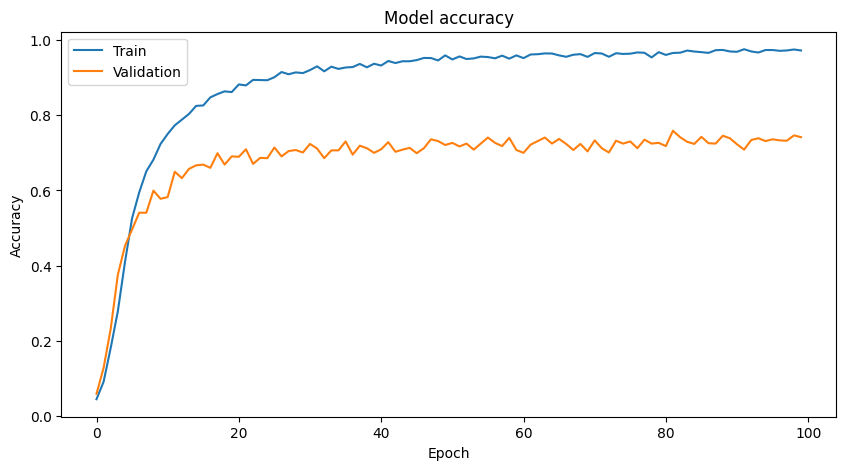

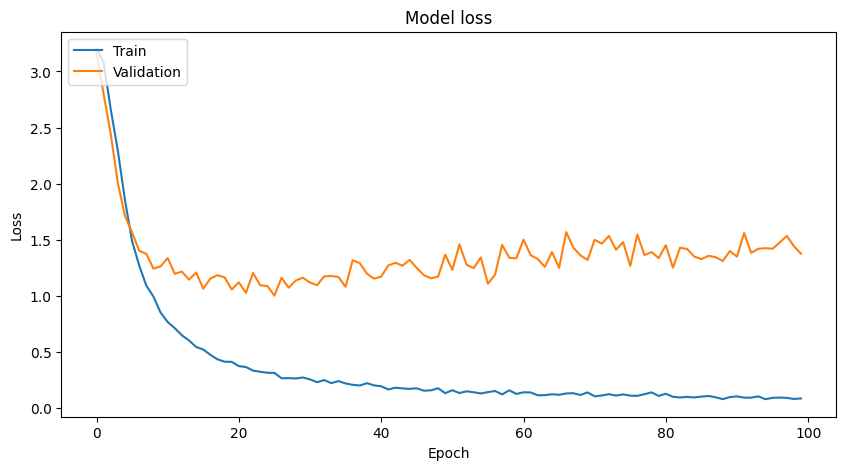

In [10]:
# Plot Training & Validation Accuracy Values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Training & Validation Loss Values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
# Load the Saved Model
model = load_model('Model_SIBIPEDIA.h5')

In [12]:
# Evaluate on Validation data
scores = model.evaluate(validation_generator, verbose=1, steps=validation_steps*10, max_queue_size=3000, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

 33/330 [==>...........................] - ETA: 47s - loss: 1.3274 - accuracy: 0.7424

330/330 [==============================] - 5s 15ms/step - loss: 1.3274 - accuracy: 0.7424
evaluate accuracy: 74.24%


In [13]:
# Function to make predictions on new images
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class] * 100
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    return predicted_label, confidence

In [14]:
# TRY 1
# Test the prediction function with a new image
img_path = '/content/dataset-sibi/skripsi/A/1645707869.4431655.jpg'
predicted_label, confidence = predict_image(img_path)
print(f'The predicted label for the image is: {predicted_label} ({confidence:.2f}%)')

1/1 [==============================] - 0s 328ms/step
The predicted label for the image is: A (100.00%)


In [15]:
# TRY 2
# Test the prediction function with a new image
img_path = '/content/dataset-sibi/skripsi/O/1645708888.7528524.jpg'
predicted_label, confidence = predict_image(img_path)
print(f'The predicted label for the image is: {predicted_label} ({confidence:.2f}%)')

1/1 [==============================] - 0s 18ms/step
The predicted label for the image is: O (99.48%)


In [16]:
# TRY 3
# Test the prediction function with a new image
img_path = '/content/dataset-sibi/skripsi/W/1645708743.1052845.jpg'
predicted_label, confidence = predict_image(img_path)
print(f'The predicted label for the image is: {predicted_label} ({confidence:.2f}%)')

1/1 [==============================] - 0s 25ms/step
The predicted label for the image is: W (100.00%)


In [17]:
# Load the saved Keras Model
model = tf.keras.models.load_model('Model_SIBIPEDIA.h5')

# Convert the Model to TFLite Format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite Model to a file
with open('Model_SIBIPEDIA.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite format")

Model successfully converted to TFLite format
